In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

C:\Program Files\Python37\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
C:\Program Files\Python37\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [2]:
x,y = mnist['data'], mnist['target']
x.shape

(70000, 784)

In [3]:
y.shape

(70000,)

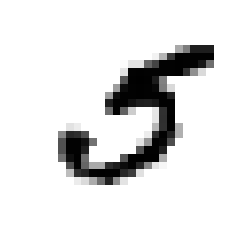

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = x[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
y[36000]

5.0

In [6]:
# Creating a test and training set

x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

# shuffling the training to set to ensure the cross validation folds will be similar.
import numpy as np
shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

In [7]:
# Identify binaries

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test ==5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

sgd_clf.predict([some_digit])

array([False])

In [8]:
### Measuring Accuracy Using Cross-Validation ###

# Implementing Cross-Validation

# Code below does the same thing as sklearn cross_val_score

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Stratified sampling. Folds that contain a representative ratio of each class. 
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints .94675, .9528, and .95165

0.913
0.96445
0.96755


In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.913  , 0.96445, 0.96755])

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.911  , 0.9076 , 0.91035])

In [11]:
# Confusion Matrix

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52703,  1876],
       [ 1224,  4197]], dtype=int64)

In [12]:
# Sklearn classifier functions

# precision score = TP/FP+TP

# recall score = TP/FN+TP

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.6910917174378396

In [13]:
recall_score(y_train_5, y_train_pred)

0.7742114001106807

In [14]:
# Calculate f1 score

# f1 score favores similar precision and recall
# f1 = 2/((1/precision)+(1/recall)) = 2*(precision*recall)/(precision+recall) = TP/(TP+(FN+FP/2))

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7302940664694623

In [15]:
# Setting precision versus recall thresholds

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-262.29583111])

In [16]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [17]:
# Raising the threshold decreases recall
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

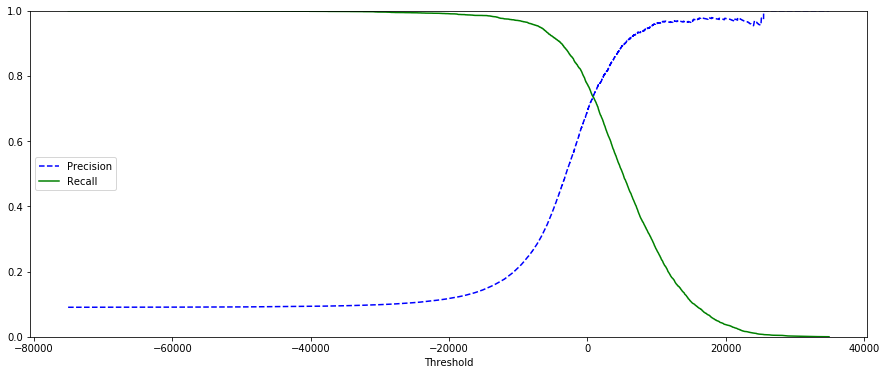

In [18]:
# Compute precision and recall for all possible thresholds using the precision_recall_curve()

y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method='decision_function')
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(15,6))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [19]:
y_train_pred_90 = (y_scores > 70000)

precision_score(y_train_5, y_train_pred_90)

C:\Program Files\Python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [20]:
recall_score(y_train_5, y_train_pred_90)

0.0

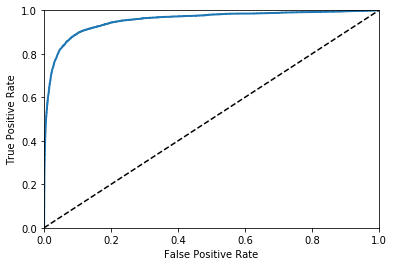

In [21]:
# The ROC Curve

# plts the true positive rate (another name for recall) against the false positive rate.
# FPR: the ratio of negative instances that are incorrectly classified as positive. 

# Comput TPR and FPR for various trheshold values.
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr,tpr)
plt.show()

In [22]:
# Further away the blue line is from the dotted line (ROC curve of a purely random classifier) the better.

# ROC AUC: area between the two ROC curves.

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9543713147312762

C:\Program Files\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


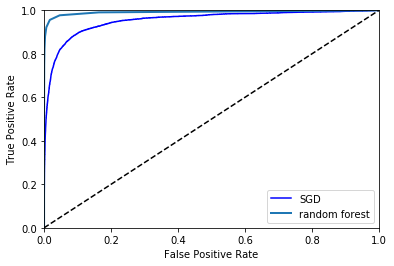

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict_proba')

# Need scores not propabilities. Use the postive slcass's probability as the score:

y_scores_forest = y_probas_forest[:, 1] # Score = proba of poisitive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr,tpr, 'b', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'random forest')
plt.legend(loc='lower right')
plt.show()

In [24]:
# ROC AUC score of the random forest
roc_auc_score(y_train_5, y_scores_forest)

# print('Precision')
# precision_score(y_train_5, y_scores_forest)

# print('Recall')
# recall_score(y_train_5, y_scores_forest)

0.9916926873960709

In [25]:
# Multiclass Classification

# Identifying more than one class. 

sgd_clf.fit(x_train, y_train) 
sgd_clf.predict([some_digit])

array([5.])

In [26]:
# The highest score is the one that coresponds to class 5
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -2108.51948161, -29611.33675672,  -6515.7323995 ,
         -1924.59528098, -19218.22034954,  -1201.51462313,
        -20001.61712073, -18959.09409349, -12021.08098366,
        -14334.90559394]])

In [27]:
np.argmax(some_digit_scores)

5

In [28]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [29]:
sgd_clf.classes_[5]

5.0

In [30]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [31]:
len(ovo_clf.estimators_)

45

In [32]:
forest_clf.fit(x_train, y_train)
forest_clf.predict([some_digit])

C:\Program Files\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5.])

In [33]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [34]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

array([0.87787443, 0.89354468, 0.87258089])

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90146971, 0.90069503, 0.89658449])

In [36]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5580,    0,   16,    6,    9,   38,   35,    5,  233,    1],
       [   0, 6417,   40,   19,    4,   42,    5,    8,  197,   10],
       [  26,   26, 5235,   92,   68,   20,   66,   41,  375,    9],
       [  28,   20,  105, 5228,    0,  199,   27,   44,  411,   69],
       [  13,   12,   33,    7, 5220,    7,   37,   21,  332,  160],
       [  34,   18,   25,  157,   53, 4448,   82,   17,  519,   68],
       [  27,   18,   39,    1,   42,   91, 5554,    5,  140,    1],
       [  20,   12,   50,   23,   48,    9,    4, 5716,  170,  213],
       [  17,   63,   40,   90,    1,  122,   29,    8, 5436,   45],
       [  25,   25,   28,   61,  119,   32,    1,  167,  350, 5141]],
      dtype=int64)

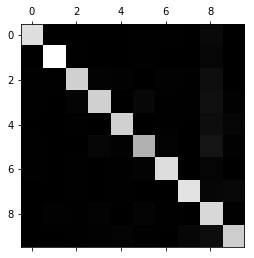

In [37]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [38]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

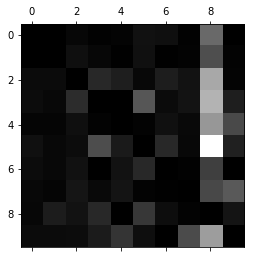

In [40]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

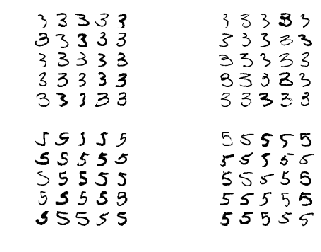

In [43]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3,5
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.subplot(221); plot_digits(x_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(x_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(x_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(x_bb[:25], images_per_row=5)
plt.show()

In [44]:
### Multilabel Classification ###

# Below code categorizes images as being large or not (large being 7,8,9) or if it is odd.

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)
knn_clf.predict([some_digit])
# The result is correct.
# 5 is not large (7,8,9)
# 5 is odd (1,3,5)

array([[False,  True]])

In [45]:
# Calculates the average f1 score across all labels
# Assumes number of classifications is equal. If the number of classifications is not equal make average="weighted"

y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9769776370337329

In [46]:
### Multioutput Classification ###

# Create a program that removes noise from an image.

# Start by creating an image with noise. 
noise = np.random.randint(0,100,(len(x_train), 784))
x_train_mod = x_train + noise 
noise = np.random.randint(0,100,(len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

ValueError: cannot reshape array of size 1 into shape (28,28)

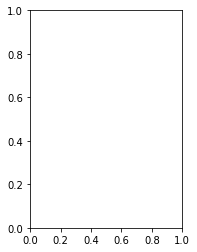

In [50]:
some_index = 5500
plt.subplot(121); plot_digits(x_test_mod[some_index])
plt.subplot(122); plot_digits(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

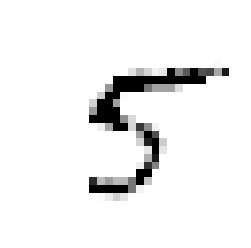

In [53]:
knn_clf.fit(x_train_mod,y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[some_index]])
plot_digits(clean_digit)